# Exploring Transformers for Sequence Modeling

In this project, I delve into the implementation and training of Transformer models. Transformers, introduced by Vaswani et al. in 2017, have revolutionized the field of natural language processing (NLP) by enabling efficient parallel processing of sequences.

This project aims to implement a Transformer model and train it on a sequence modeling task. The Transformer model's architecture, based on self-attention mechanisms, is particularly well-suited for tasks such as language modeling, translation, and more.

### Multi-Head Attention

The multi-head attention mechanism is a core component of the Transformer model. It allows the model to jointly attend to information from different representation subspaces at different positions. Here's a breakdown of how it works:

1. **Scaled Dot-Product Attention:**
   - The basic unit of attention is the scaled dot-product attention, which computes the attention scores between queries (Q), keys (K), and values (V). The scores determine how much focus to place on different parts of the input sequence.
   - The attention mechanism is defined as:
     $
     \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
     $
     where $d_k$ is the dimension of the keys.

2. **Multi-Head Mechanism:**
   - Instead of performing a single attention function, the multi-head mechanism splits the queries, keys, and values into multiple heads, each of which performs attention separately. The results are then concatenated and linearly transformed to produce the final output.
   - This allows the model to capture different types of dependencies and relationships in the input sequence.

3. **Implementation:**
   - The multi-head attention is implemented by first linearly projecting the queries, keys, and values $h$ times with different learned projections, then applying the scaled dot-product attention in parallel, and finally concatenating the results.

The multi-head attention mechanism enhances the model's ability to focus on different parts of the sequence and learn various aspects of the data simultaneously.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import matplotlib.pyplot as plt

class MultiHeadAttention(nn.Module):
    def __init__(self, d_embedding, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_embedding % n_heads == 0

        self.d_embedding = d_embedding
        self.n_heads = n_heads
        self.d_k = d_embedding // n_heads

        self.W_q = nn.Linear(d_embedding, d_embedding)
        self.W_k = nn.Linear(d_embedding, d_embedding)
        self.W_v = nn.Linear(d_embedding, d_embedding)
        self.W_o = nn.Linear(d_embedding, d_embedding)

    def compute_attention_probs(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def make_heads(self, x):
        batch_size, seq_length, d_embedding = x.size()
        y = x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)
        return x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)

    def join_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_embedding)

    def forward(self, Q, K, V, mask=None):
        Q = self.make_heads(self.W_q(Q)) # Replace Q with Q*W^q
        K = self.make_heads(self.W_k(K)) # Replace K with K*W^k
        V = self.make_heads(self.W_v(V)) # Replace V with V*W^v

        x = self.compute_attention_probs(Q, K, V, mask) # Compute attention scores
        x = self.join_heads(x) # Join the heads (concatenation)
        x = self.W_o(x) # Final linear layer
        return x

### Feedforward Neural Network

The feedforward neural network (FFN) is another crucial component in both the encoder and decoder blocks of the Transformer model. It operates on each position of the sequence independently and identically. Here's an overview of the feedforward network:

1. **Two Linear Layers with ReLU Activation:**
   - The FFN consists of two linear transformations with a ReLU activation in between. This introduces non-linearity into the model, enabling it to capture more complex patterns in the data.
   - The transformation is defined as:
     $
      \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
     $
     where $W_1$ and $W_2$ are weight matrices, and $b_1$ and $b_2$ are bias terms.

2. **Position-wise Application:**
   - Unlike traditional feedforward layers that are applied to the entire input, the FFN in the Transformer is applied to each position separately and identically. This means that the same feedforward network is used for each token in the sequence.

3. **Dimension Expansion and Reduction:**
   - The first linear layer expands the dimension from $d_{\text{model}}$ to a higher dimension (typically four times larger), and the second linear layer reduces it back to $d_{\text{model}}$. This allows the model to learn more complex representations within the higher-dimensional space.

The feedforward neural network helps the Transformer model to process and transform the input representations, adding another layer of abstraction and enabling it to learn more sophisticated features from the data.

In [2]:
class FeedForward(nn.Module):
    def __init__(self, d_embedding, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_embedding, d_ff)
        self.fc2 = nn.Linear(d_ff, d_embedding)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Encoder block

The first part of the Transformer mechanism comprises the Encoder block. This block, as the name suggests, is in charge of producing intermediate encodings for the input which the model decodes in the next part, which is the Decoder block.

Each encoder block consists of the following components:

1. **Multi-head Self-Attention Mechanism:** This mechanism allows the model to focus on different parts of the input sequence when encoding a particular token. By using multiple heads, the model can capture various aspects of the relationships between tokens.

2. **Feedforward Neural Network:** A fully connected feedforward neural network is applied to each position separately and identically. It consists of two linear transformations with a ReLU activation in between.

3. **Layer Normalization:** Layer normalization is applied after the self-attention and feedforward networks to stabilize and speed up the training process.

4. **Residual Connections (Skip Connections):** Residual connections are used to help the flow of gradients during backpropagation. The input to each sub-layer is added to its output, and the result is normalized.

The combination of these components allows the encoder to effectively capture the dependencies and relationships within the input sequence.

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, d_embedding, n_heads, d_ff, dropout):
        super(EncoderBlock, self).__init__()
        self.self_attention = MultiHeadAttention(d_embedding, n_heads)
        self.feed_forward = FeedForward(d_embedding, d_ff)
        self.norm1 = nn.LayerNorm(d_embedding)
        self.norm2 = nn.LayerNorm(d_embedding)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        Returns: The output of encoder on a given input batch x
        """
        # First, pass the input through the multi-head self-attention layer
        attn_output = self.self_attention(x, x, x, mask)

        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output)

        # Add the input x to the output of the dropout layer as a residual connection, then apply layer normalization
        x = self.norm1(x + attn_output)

        # Pass the output through the feed-forward network
        ff_output = self.feed_forward(x)

        # Apply dropout to the feed-forward network output
        ff_output = self.dropout2(ff_output)

        # Add the output of the feed-forward layer to x as a residual connection, then apply layer normalization
        x = self.norm2(x + ff_output)

        return x

### Decoder Block

The decoder block in the Transformer model is designed to generate output sequences by attending to both the encoder outputs and the previously generated tokens. Each decoder block consists of the following components:

1. **Masked Multi-head Self-Attention Mechanism:** This mechanism allows the decoder to attend to different parts of the output sequence generated so far while ensuring that predictions for a particular position depend only on the known outputs at positions before it.

2. **Multi-head Attention Mechanism:** This layer attends to the encoder's output, allowing the decoder to focus on relevant parts of the input sequence. It helps the decoder to use information from the entire input sequence while generating each token of the output.

3. **Feedforward Neural Network:** Similar to the encoder, a fully connected feedforward neural network is applied to each position separately and identically.

4. **Layer Normalization:** Layer normalization is applied after each attention and feedforward network to stabilize and speed up the training process.

5. **Residual Connections (Skip Connections):** Residual connections are used to facilitate the flow of gradients during backpropagation. The input to each sub-layer is added to its output, and the result is normalized.

These components enable the decoder to generate coherent and contextually appropriate sequences by attending to the encoder outputs and the previously generated tokens.

In [4]:
class DecoderBlock(nn.Module):
    def __init__(self, d_embedding, n_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()
        """
        Args:
           self_attention: decoder's multi-head attention
           cross_attention: The multi-head attention layer between the encoder and the decoder
           feed_forward: feed-forward layer
           mask: mask to be given for multi head attention
           norm1: First Normalization layer
           norm2: Second Normalization layer
           norm3: Third Normalization layer
           dropout: Final dropout layer
        """
        self.self_attention = MultiHeadAttention(d_embedding, n_heads)
        self.cross_attention = MultiHeadAttention(d_embedding, n_heads)
        self.feed_forward = FeedForward(d_embedding, d_ff)
        self.norm1 = nn.LayerNorm(d_embedding)
        self.norm2 = nn.LayerNorm(d_embedding)
        self.norm3 = nn.LayerNorm(d_embedding)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        """
        Returns: The output of decoder on a given input batch x
        """
        # Self-attention
        attn_output = self.self_attention(x, x, x, tgt_mask)
        attn_output = self.dropout1(attn_output)
        x = self.norm1(x + attn_output)  # Apply residual connection and normalize

        # Cross-attention
        cross_attn_output = self.cross_attention(x, enc_output, enc_output, src_mask)
        cross_attn_output = self.dropout2(cross_attn_output)
        x = self.norm2(x + cross_attn_output)  # Apply residual connection and normalize

        # Feed-forward
        ff_output = self.feed_forward(x)
        ff_output = self.dropout3(ff_output)
        x = self.norm3(x + ff_output)  # Apply residual connection and normalize

        return x

## Positional encoding

The last part we need to implement the Transformer block is the positional encoding block. Positional encoding is an essential part of the transformer because it helps assign semantic weightage to words depending on their order (or "position") in the sequence - therefore, words "closer" to the current word will have more "importance" and vice versa.

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_embedding, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_embedding)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embedding, 2).float() * -(math.log(10000.0) / d_embedding))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

## Putting It All Together

The Transformer model consists of a stack of identical encoder and decoder blocks. The encoder processes the input sequence and generates a set of attention-based representations. The decoder then uses these representations, along with the previously generated tokens, to produce the output sequence.

By leveraging self-attention and multi-head attention mechanisms, the Transformer model can capture complex dependencies and relationships within the data, making it highly effective for various sequence modeling tasks.

In [6]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_embedding, n_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_embedding)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_embedding)
        self.positional_encoding = PositionalEncoding(d_embedding, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderBlock(d_embedding, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderBlock(d_embedding, n_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_embedding, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    # Masking the input; the outputs returned by this function should be passed to encoder and decoder layers
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        """
        Returns: The output of transformer on a given input batch x
        """
        src_mask, tgt_mask = self.generate_mask(src, tgt)

        # Pass the input through the encoder layers
        x = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, src_mask)

        # Pass the input through the decoder layers
        y = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        for decoder_layer in self.decoder_layers:
            y = decoder_layer(y, x, src_mask, tgt_mask)

        # Apply dropout to the output of the decoder layers
        # y = self.dropout(y)
        y = self.fc(y)

        return y

## Training

We train the Transformer model using appropriate loss functions and optimization techniques. The model aims to learn patterns in the sequence data and improve its performance on the given task over multiple epochs. We will track the training process and monitor the model's performance. Since the loss function output goes down with the epochs, we understand that the transformer is training correctly and behaving as expected.

In [7]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_embedding = 512
n_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1
EPOCHS = 25
training_loss = []

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_embedding, n_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data)
    loss = criterion(output.view(-1, tgt_vocab_size), tgt_data.view(-1))
    # output = transformer(src_data, tgt_data[:, :-1])
    # loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))

    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

    training_loss.append(loss.item())

torch.save(transformer.state_dict(), "./etc/transformer")

Epoch [1/25], Loss: 8.6774
Epoch [2/25], Loss: 8.5359
Epoch [3/25], Loss: 8.4435
Epoch [4/25], Loss: 8.3526
Epoch [5/25], Loss: 8.2394
Epoch [6/25], Loss: 8.1204
Epoch [7/25], Loss: 7.9994
Epoch [8/25], Loss: 7.8808
Epoch [9/25], Loss: 7.7657
Epoch [10/25], Loss: 7.6479
Epoch [11/25], Loss: 7.5275
Epoch [12/25], Loss: 7.4031
Epoch [13/25], Loss: 7.2949
Epoch [14/25], Loss: 7.1699
Epoch [15/25], Loss: 7.0571
Epoch [16/25], Loss: 6.9397
Epoch [17/25], Loss: 6.8277
Epoch [18/25], Loss: 6.7123
Epoch [19/25], Loss: 6.5990
Epoch [20/25], Loss: 6.4911
Epoch [21/25], Loss: 6.3798
Epoch [22/25], Loss: 6.2721
Epoch [23/25], Loss: 6.1610
Epoch [24/25], Loss: 6.0599
Epoch [25/25], Loss: 5.9536


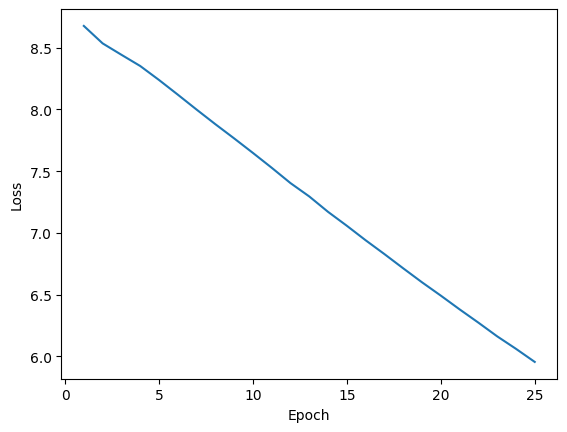

In [8]:
plt.plot(list(range(1, EPOCHS+1)), training_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()